## Testing Reading Files
This Notebook will demonstrate how I will extract all of the sources rom a fits file and create cutouts from them using the fits WCS and the HSC. This is one of two ways that I could potentially start scanning the archive. 

In [62]:
from zoobot.tensorflow.data_utils import image_datasets
from zoobot.tensorflow.estimators import preprocess, define_model
from zoobot.tensorflow.predictions import predict_on_dataset

from astroquery.mast import Catalogs

from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uuid
import io
import os
import ast
import shutil
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers

## Loading in Zoobot Model

In [2]:
initial_size = 300
crop_size = int(0.75 * initial_size)
resize_size = 224
pretrained_checkpoint = 'C:/Users/oryan/Documents/zoobot_new/pretrained-models/replicated_train_only_greyscale_tf/replicated_train_only_greyscale_tf/checkpoint'
finetuned_loc = 'C:/Users/oryan/Documents/zoobot_new/model-logs/2022-05-05-HEC-all-unfrozen-0.89/finetuned/checkpoint'

In [3]:
base_model = define_model.load_model(
    pretrained_checkpoint,
    include_top = False,
    input_size = initial_size,
    crop_size = crop_size,
    resize_size = resize_size,
    output_dim = None,
    channels = 1,
    expect_partial = True
)

In [4]:
para_relu = layers.PReLU()

In [5]:
## Note, this must be identical to how the model was trained!!!
model_head = tf.keras.Sequential([
    layers.InputLayer(input_shape=(7,7,1280)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64,activation=para_relu),
        #layers.Dropout(0.75),
        layers.Dense(64,activation='elu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(64,activation = para_relu),
        layers.Dropout(0.25),
        layers.Dense(1,activation='sigmoid',name='sigmoid_output')
])

In [6]:
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(initial_size, initial_size,1)),
        base_model,
        model_head
    ])

In [7]:
model.load_weights(finetuned_loc).expect_partial()

Process:

    1. Load in the Fits file
    2. Extract the WCS and get a footprint/region from it.
    3. Query the HSC for this region. Have cutouts of every object!

In [8]:
file = 'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ2000a03/mastDownload/HST/hst_10092_0g_acs_wfc_f814w_j8xi0g/hst_10092_0g_acs_wfc_f814w_j8xi0g_drc.fits'

In [9]:
with fits.open(file) as hdul:
    wcs = WCS(hdul[1].header)
    data = hdul[1].data

In [10]:
region = WCS.calc_footprint(wcs)

In [11]:
central_coord = wcs.pixel_to_world(int(data.shape[0]/2), int(data.shape[1]/2))

In [12]:
catalogue_data = Catalogs.query_region(central_coord,radius = 0.05, catalog="HSC")

In [13]:
print(len(catalogue_data))

1649


In [14]:
ra = catalogue_data['MatchRA']
dec = catalogue_data['MatchDec']
matchid = catalogue_data['MatchID']

In [15]:
coords = {}
for i in range(len(ra)):
    coord = SkyCoord(ra = ra[i] * u.deg, dec = dec[i] * u.deg, frame='fk5')
    if wcs.footprint_contains(coord):
        coords[matchid[i]] = coord

In [16]:
print(len(catalogue_data))
print(len(coords))

1649
1040


In [17]:
pixels = np.zeros([len(coords),2])
counter = 0
for i in list(coords.keys()):
    pixel_coords = wcs.world_to_pixel(coords[i])
    pixels[counter,0] = pixel_coords[0]
    pixels[counter,1] = pixel_coords[1]
    counter += 1

In [18]:
data.shape

(4927, 5088)

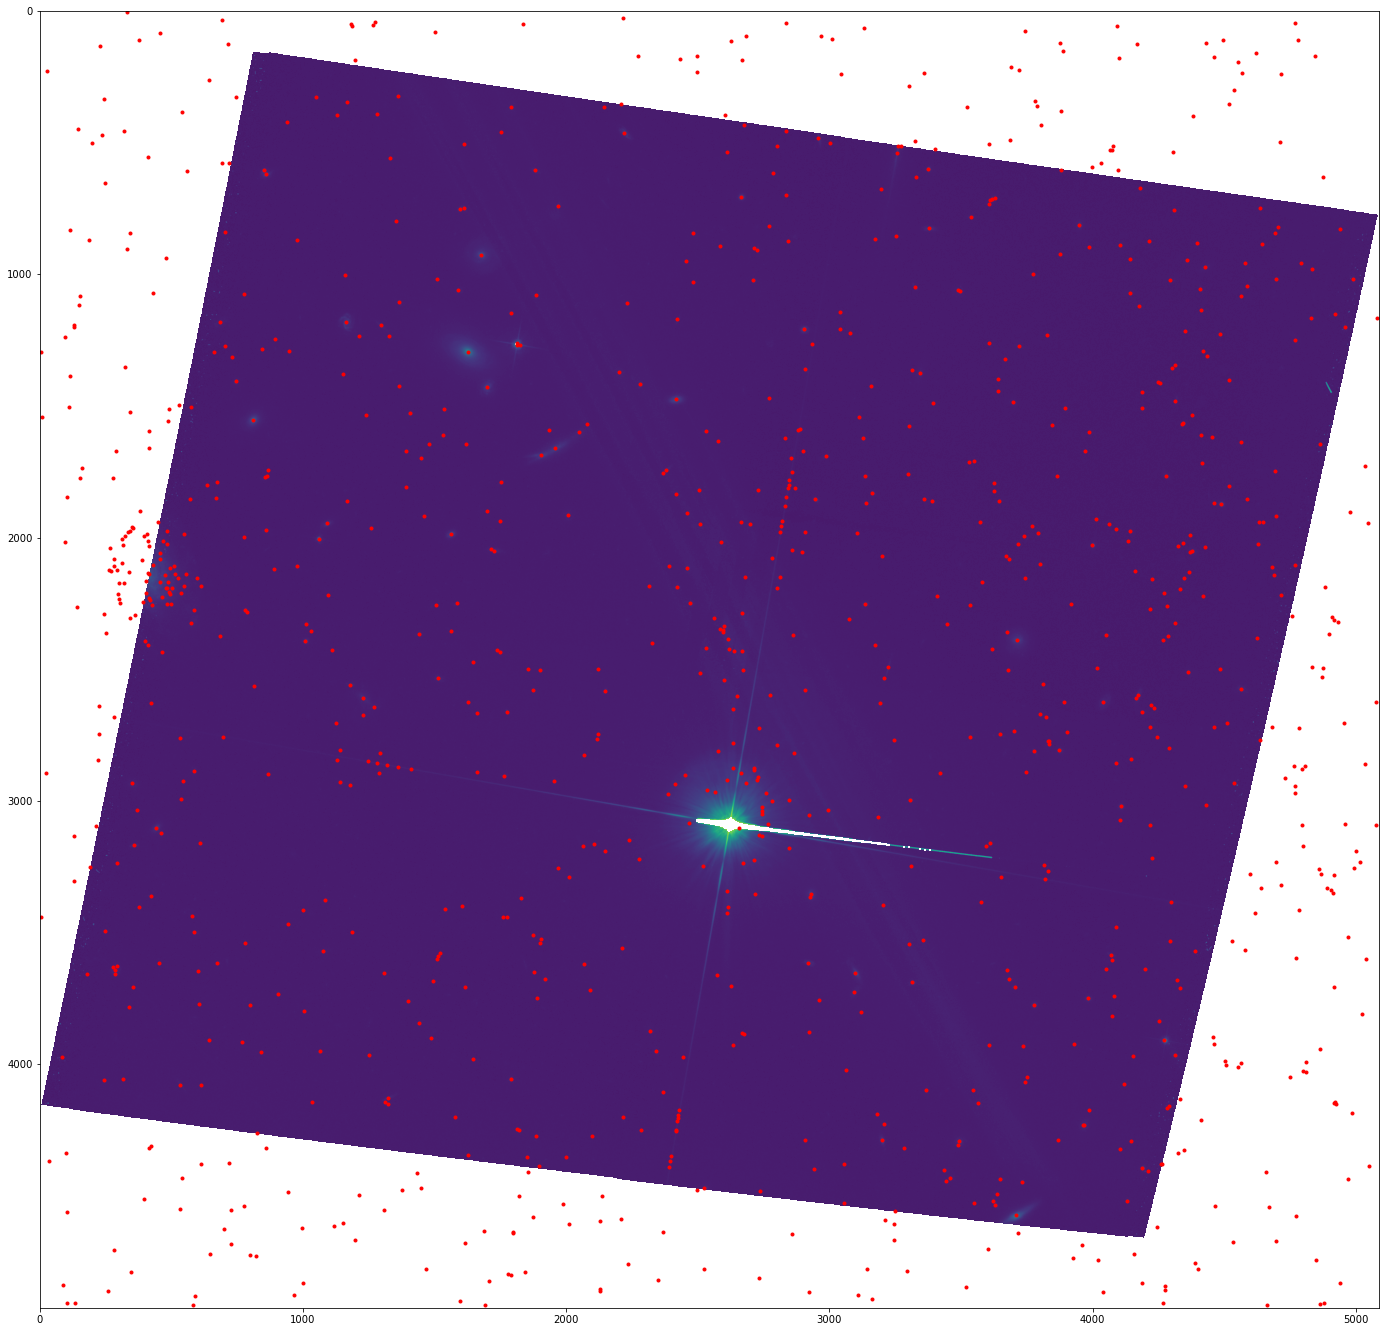

In [19]:
plt.figure(figsize=(24,24))
plt.imshow(np.log10(data))
for i in range(len(pixels)):
    plt.scatter(pixels[i,0],pixels[i,1],color='red',marker='.')

Must now create the cutouts and see what we're looking at!

In [20]:
save_folder = 'C:/Users/oryan/Documents/esac-project/cutouts/tmp'

In [21]:
# %%time
# for i in coords[:1]:
#     try:
#         cutout = Cutout2D(data,i,(100,100),wcs=wcs,mode='strict')
#     except:
#         continue
#     tmp = len(cutout.data[np.isnan(cutout.data)])
#     if tmp > 10:
#         continue
#     else:
#         norm = ImageNormalize(
#         cutout.data,
#         interval=ZScaleInterval(nsamples=5000,contrast = 0.05),
#         stretch=LinearStretch(),
#         clip=True
#         )
        
#         tmp = uuid.uuid4()

#         plt.figure(figsize=(12,12))
#         plt.imshow(cutout.data,cmap='Greys_r',norm=norm)
#         plt.axis('off')
#         plt.savefig(f'{save_folder}/{tmp}.png', dpi=300, bbox_inches='tight',pad_inches=0)
#         plt.close()
        
#         im = Image.open(f'{save_folder}/{tmp}.png')
#         im.thumbnail([300,300])
#         im.save(f'{save_folder}/{tmp}_thumb.png')

In [63]:
%%time
buf = io.BytesIO()
buf.seek(0)
im_dict = {}
for i in tqdm(list(coords.keys())):
    coord = coords[i]
    try:
        cutout = Cutout2D(data,coord,(150,150),wcs=wcs,mode='strict')
    except:
        continue
    tmp = len(cutout.data[np.isnan(cutout.data)])
    if tmp > 10:
        continue
    else:
        norm = ImageNormalize(
        cutout.data,
        interval=ZScaleInterval(nsamples=1000,contrast = 0.005),
        stretch=LinearStretch(),
        clip=True
        )
        
        tmp = uuid.uuid4()

        plt.figure(figsize=(12,12))
        plt.imshow(cutout.data,cmap='Greys_r',norm=norm)
        plt.axis('off')
        buf = io.BytesIO()
        buf.seek(0)
        plt.savefig(buf, dpi=300, bbox_inches='tight',pad_inches=0)
        plt.close()
        
        
        im = Image.open(buf)
        im_grey = im.convert('RGB')
        im_grey.thumbnail([300,300])
        im_grey.save(f'{save_folder}/{i}.png')
        im_dict[i] = [f'{save_folder}/{i}.png']

100%|██████████| 1040/1040 [17:43<00:00,  1.02s/it]

Wall time: 17min 43s


## Now, the Predictions...

In [64]:
image_paths = (
    pd.DataFrame(im_dict)
    .T
    .reset_index()
    .rename(columns={'index':'id_str',0:'file_loc'})
)

In [65]:
initial_size = 300
batch_size = 256
file_format = 'png'

In [66]:
raw_image_ds = image_datasets.get_image_dataset([x for x in image_paths.file_loc], file_format, initial_size, batch_size)

In [67]:
preprocessing_config = preprocess.PreprocessingConfig(
    label_cols = [],
    input_size = initial_size,
    make_greyscale = True,
    normalise_from_uint8 = True
)

In [68]:
image_ds = preprocess.preprocess_dataset(raw_image_ds, preprocessing_config)

In [69]:
n_samples = 1
label_cols = ['interacting']
filename = os.path.splitext(os.path.basename(file))[0]
save_loc = f'C:/Users/oryan/Documents/esac-project/predictions/pred_sources_{filename}.csv'

In [70]:
predictions = predict_on_dataset.predict(image_ds,model,1,label_cols, save_loc, ret_flag=True)

In [71]:
predictions

,id_str,interacting_pred
0,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.1446981132030487]
1,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.20066803693771362]
2,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.2806277573108673]
3,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.15709030628204346]
4,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.6378651261329651]
...,...,...
625,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.09558755159378052]
626,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.08467444777488708]
627,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.06520375609397888]
628,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.06104421615600586]


In [72]:
cut = 0.55

In [73]:
predictions_export = (
    predictions
    .assign(matchid = predictions.id_str.apply(lambda x: os.path.splitext(os.path.basename(x))[0]))
    .assign(binary_prediction = predictions.interacting_pred.apply(lambda x: 1 if ast.literal_eval(x)[0] > cut else 0))
    .rename(columns={'id_str':'file_path'})
)

In [74]:
predictions_export

,file_path,interacting_pred,matchid,binary_prediction
0,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.1446981132030487],36991314,0
1,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.20066803693771362],45671917,0
2,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.2806277573108673],68811448,0
3,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.15709030628204346],55325648,0
4,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.6378651261329651],1563266,1
...,...,...,...,...
625,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.09558755159378052],26392199,0
626,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.08467444777488708],70890583,0
627,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.06520375609397888],87124631,0
628,C:/Users/oryan/Documents/esac-project/cutouts/...,[0.06104421615600586],48233374,0


In [75]:
predictions_export.binary_prediction.value_counts()

0    545
1     85
Name: binary_prediction, dtype: int64

In [76]:
shutil.rmtree(save_folder)

In [77]:
os.mkdir(save_folder)